In [1]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

from Model.TSNEGCNModel import GCNModel
import torch

In [2]:
from CollateFn.CollateFnBase import CollateFnBase

In [3]:
model=GCNModel(pretrained_model = "xlm-roberta-base", label_num=len("BIEOS"), gcn_dim=128, gcn_num=2, gcn_mode=3, stanzaTokenNerDim=12, stanzaTokenPosDim=8)
# model=GCNModel(pretrained_model = "xlm-roberta-base", label_num=len("BIEOS"), gcn_dim=0, gcn_num=0, gcn_mode=3, stanzaTokenNerDim=0, stanzaTokenPosDim=0)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
# model.load_state_dict(torch.load('./TSNE/best_spanish_0_0_0_0.pkl'))
model.load_state_dict(torch.load('./TSNE/best_spanish_128_2_12_8.pkl'))

<All keys matched successfully>

In [5]:
model = model.to('cuda')

In [6]:
from Dataset.SemEval16Task5Dataset import SemEvalXMLDataset
from torch.utils.data import DataLoader

from ArgumentParser.GCNArgParser import GCNArgumentParser
from Dataset.SemEval16Task5Dataset import SemEvalXMLDataset

argument = GCNArgumentParser()
dataParams = argument.parse_args()

testEsDataset = SemEvalXMLDataset(phrase="Test", language="spanish")
testFrDataset = SemEvalXMLDataset(phrase="Test", language="french")

from CollateFn.CollateFnXLMRGCN import CollateFnXLMRGCN
collateFnXLMRGCN = CollateFnXLMRGCN(pretrained_model_name_or_path="xlm-roberta-base")

testEsDataLoader = DataLoader(testEsDataset, batch_size=dataParams.Batchsize, collate_fn=collateFnXLMRGCN.collate_fn, shuffle=False, drop_last=False)
testFrDataLoader = DataLoader(testFrDataset, batch_size=dataParams.Batchsize, collate_fn=collateFnXLMRGCN.collate_fn, shuffle=False, drop_last=False)


environment  notebook
Namespace(Batchsize=16, GCNEmbedDim=0, GCNLayerNum=0, GCNModelMode=3, LearningRate=4e-05, NEREmbedDim=0, POSEmbedDim=0, PretrainModel=None, RecordsDir='RecordsDir', Source='english', Task='ATESP', TrainEpochs=20)

Get 881 sentence from /root/GCNXLMRLanguageATE/Dataset/SemEval_2016_Task5/Restaurant_Test_Subtask1/restaurants_test_spanish_subtask1.xml 
The first data is ('La comida estuvo muy sabrosa.', [Target:comida | C:FOOD#QUALITY | P:positive | Begin:3 | End:9], 'Test', 'spanish', 'Restaurant', 'es_9reinas_0_MonicaNavarroOlive_2015-04-19', 'es_9reinas_0_MonicaNavarroOlive_2015-04-19:0')

Get 668 sentence from /root/GCNXLMRLanguageATE/Dataset/SemEval_2016_Task5/Restaurant_Test_Subtask1/restaurants_test_french_subtask1.xml 
The first data is ('Après le palais du facteur nous voici à la halte qui est un restaurant correct.', [Target:restaurant | C:RESTAURANT#GENERAL | P:neutral | Begin:60 | End:70], 'Test', 'french', 'Restaurant', 'g1368199-d3726982-r258755756', '

In [7]:
# 优化层
from torch import optim
from torch.optim import lr_scheduler

optimizer = optim.Adam(model.parameters(), lr=5e-5)
scheduler = lr_scheduler.StepLR(optimizer, 4, gamma=0.7)

from torch.nn import NLLLoss
criterion = NLLLoss()

In [8]:
def concat(epochModelOutputs):
    embeddingsList = []
    Pred = []
    Gold = []
    for miniBatch in epochModelOutputs:
        embeddingsList.append(miniBatch['token_embeddings'])
        Gold.extend(miniBatch['batchLabelsEncode']['batchFlattenIds'])
        batchPredFlattenLabelsId = np.argmax(miniBatch['tokenLogSoftmax'], axis=1).tolist()
        Pred.extend(batchPredFlattenLabelsId)
    
    embeddings = np.concatenate(embeddingsList, axis=0)
    return {
        'embeddingsNP': embeddings,
        'pred_labels': Pred,
        'gold_labels': Gold
    }

In [9]:
model = model.to("cuda")

In [10]:
from Model.TSNEModelRun import GCNModelRun


epochEsModelOutputs = GCNModelRun.runEpochModel(model, criterion, testEsDataLoader, optimizer, scheduler, isTrain=False, DEVICE="cuda")
epochFrModelOutputs = GCNModelRun.runEpochModel(model, criterion, testFrDataLoader, optimizer, scheduler, isTrain=False, DEVICE="cuda")

100%|██████████| 42/42 [00:06<00:00,  6.67it/s]


In [11]:
testEsResult = concat(epochEsModelOutputs)
testFrResult = concat(epochFrModelOutputs)

In [12]:
idx2tag, tag2idx = CollateFnBase.ATEid2label, CollateFnBase.ATElabel2id

In [13]:
def drawTSNE(testEsResult, testFrResult, idx2tag, tag2idx, dim=768):
    trainResults= testEsResult #gettSNEData(args, trainDataset, model, args.idx2tag, mode='dev')
    # 返回embeddings{'embeddings': x}
    testResults = testFrResult # gettSNEData(args, testDataset, model, args.idx2tag, mode='dev')
    '''
    nums=[]
    for tag in [key for key in args.tag2idx.keys()]:
        num=sum(list(testResults['gold_labels']==args.tag2idx[tag]))
        nums.append(num)
    print(nums)
    num=min(nums)
    print(num)
    '''
    if True:
        trainResults['embeddings'] = torch.from_numpy(trainResults['embeddingsNP'])
        testFrResult['embeddings'] = torch.from_numpy(testFrResult['embeddingsNP'])

        trainResults['gold_labels'] = torch.LongTensor(trainResults['gold_labels'])
        testFrResult['gold_labels'] = torch.LongTensor(testResults['gold_labels'])

        trainResults['pred_labels'] = torch.LongTensor(trainResults['pred_labels'])
        testFrResult['pred_labels'] = torch.LongTensor(testResults['pred_labels'])

    embeddingTrain=[]
    goldY=[]
    predY=[]
    numTag=0
    goldYTrain=[]
    for tag in [key for key in tag2idx.keys()]:
        mask=trainResults['gold_labels']==tag2idx[tag]
        num=sum(mask)
        num=min(int(sum(mask)), 200)
        
        embeddingTrain.append(trainResults['embeddings'][mask][:num,:])
        numTag=numTag+1
        goldYTrain.extend([tag]*num)
    embeddingTest=[]

    for tag in [key for key in tag2idx.keys()]:
        mask=testResults['gold_labels']==tag2idx[tag]
        num=sum(mask)
        num=min(int(sum(mask)), 200)

        embeddingTest.append(testResults['embeddings'][mask][:num,:])
        goldY.extend([tag]*num)
        predY.extend(testResults['pred_labels'][mask][:num])
    
    embeddingTrain=torch.cat(embeddingTrain)
    embeddingTest=torch.cat(embeddingTest)

    embeddings=torch.cat([embeddingTrain,embeddingTest])

    tsne = TSNE(init='pca',perplexity=50,random_state=20,n_jobs=32)
    x = tsne.fit_transform(embeddings)
    xTrain=x[:embeddingTrain.shape[0],:]
    xTest=x[embeddingTrain.shape[0]:,:]
    pathName = "TSNE/outputBefore/"

    print('tsne image saved in ',pathName)
    plt.figure()
    sns.scatterplot(xTrain[:,0], xTrain[:,1], hue=goldYTrain, legend='full', palette=sns.color_palette("bright",numTag))
    plt.ylim(-100,100)
    plt.xlim(-100,100)
    plt.savefig(pathName+'tsne_train.png')

    plt.figure()
    sns.scatterplot(xTest[:,0], xTest[:,1], hue=goldY, legend='full', palette=sns.color_palette("bright",numTag))
    plt.ylim(-100,100)
    plt.xlim(-100,100)
    plt.savefig(pathName+'tsne_test_gold.png')

    plt.figure()
    sns.scatterplot(xTest[:,0], xTest[:,1], hue=[idx2tag[int(i)] for i in predY], legend='full', size=0.1)
    plt.ylim(-100,100)
    plt.xlim(-100,100)
    plt.savefig(pathName+'tsne_test_pred.png')

    plt.figure()
    sns.scatterplot(xTrain[:,0], xTrain[:,1], hue=goldYTrain, legend='full', palette=sns.color_palette("bright",numTag))
    sns.scatterplot(xTest[:,0], xTest[:,1], hue=['gold'+i for i in goldY], legend='full', palette=sns.color_palette("bright",numTag))
    sns.scatterplot(xTest[:,0], xTest[:,1], hue=['pred'+idx2tag[int(i)] for i in predY], legend='full')
    plt.ylim(-100,100)
    plt.xlim(-100,100)
    plt.savefig(pathName+'tsne_all.png')

In [14]:
def drawTSNE(testEsResult, testFrResult, idx2tag, tag2idx, dim=768):
    trainResults= testEsResult #gettSNEData(args, trainDataset, model, args.idx2tag, mode='dev')
    # 返回embeddings{'embeddings': x}
    testResults = testFrResult # gettSNEData(args, testDataset, model, args.idx2tag, mode='dev')
    '''
    nums=[]
    for tag in [key for key in args.tag2idx.keys()]:
        num=sum(list(testResults['gold_labels']==args.tag2idx[tag]))
        nums.append(num)
    print(nums)
    num=min(nums)
    print(num)
    '''
    if True:
        trainResults['embeddings'] = torch.from_numpy(trainResults['embeddingsNP'])
        testFrResult['embeddings'] = torch.from_numpy(testFrResult['embeddingsNP'])

        trainResults['gold_labels'] = torch.LongTensor(trainResults['gold_labels'])
        testFrResult['gold_labels'] = torch.LongTensor(testResults['gold_labels'])

        trainResults['pred_labels'] = torch.LongTensor(trainResults['pred_labels'])
        testFrResult['pred_labels'] = torch.LongTensor(testResults['pred_labels'])

    embeddingTrain=[]
    goldY=[]
    predY=[]
    numTag=0
    goldYTrain=[]
    for tag in [key for key in tag2idx.keys()]:
        mask=trainResults['gold_labels']==tag2idx[tag]
        num=sum(mask)
        """
        if tag=="O":
            num=min(int(sum(mask)), 500)
        elif tag=="B" or tag=="E":
            num=min(int(sum(mask)), 100)
        else:
            num=min(int(sum(mask)), 300)
                """

        embeddingTrain.append(trainResults['embeddings'][mask][:num,:])
        numTag=numTag+1
        goldYTrain.extend([tag]*num)
    embeddingTest=[]

    for tag in [key for key in tag2idx.keys()]:
        mask=testResults['gold_labels']==tag2idx[tag]
        num=sum(mask)

        """

        if tag=="O":
            num=min(int(sum(mask)), 500)
        elif tag=="B" or tag=="E":
            num=min(int(sum(mask)), 100)
        else:
            num=min(int(sum(mask)), 300)
        """

        embeddingTest.append(testResults['embeddings'][mask][:num,:])
        goldY.extend([tag]*num)
        predY.extend(testResults['pred_labels'][mask][:num])
    
    embeddingTrain=torch.cat(embeddingTrain)
    embeddingTest=torch.cat(embeddingTest)

    embeddings=torch.cat([embeddingTrain,embeddingTest])

    tsne = TSNE(init='pca',perplexity=50,random_state=20,n_jobs=32)
    x = tsne.fit_transform(embeddings)
    xTrain=x[:embeddingTrain.shape[0],:]
    xTest=x[embeddingTrain.shape[0]:,:]
    pathName = "TSNE/outputBefore/"
    
    return x, xTrain, xTest


"""
    print('tsne image saved in ',pathName)
    plt.figure()
    sns.scatterplot(xTrain[:,0], xTrain[:,1], hue=goldYTrain, legend='full', palette=sns.color_palette("bright",numTag))
    plt.ylim(-100,100)
    plt.xlim(-100,100)
    plt.savefig(pathName+'tsne_train.png')

    plt.figure()
    sns.scatterplot(xTest[:,0], xTest[:,1], hue=goldY, legend='full', palette=sns.color_palette("bright",numTag))
    plt.ylim(-100,100)
    plt.xlim(-100,100)
    plt.savefig(pathName+'tsne_test_gold.png')

    plt.figure()
    sns.scatterplot(xTest[:,0], xTest[:,1], hue=[idx2tag[int(i)] for i in predY], legend='full', size=0.1)
    plt.ylim(-100,100)
    plt.xlim(-100,100)
    plt.savefig(pathName+'tsne_test_pred.png')

    plt.figure()
    sns.scatterplot(xTrain[:,0], xTrain[:,1], hue=goldYTrain, legend='full', palette=sns.color_palette("bright",numTag))
    sns.scatterplot(xTest[:,0], xTest[:,1], hue=['gold'+i for i in goldY], legend='full', palette=sns.color_palette("bright",numTag))
    sns.scatterplot(xTest[:,0], xTest[:,1], hue=['pred'+idx2tag[int(i)] for i in predY], legend='full')
    plt.ylim(-100,100)
    plt.xlim(-100,100)
    plt.savefig(pathName+'tsne_all.png')
"""


'\n    print(\'tsne image saved in \',pathName)\n    plt.figure()\n    sns.scatterplot(xTrain[:,0], xTrain[:,1], hue=goldYTrain, legend=\'full\', palette=sns.color_palette("bright",numTag))\n    plt.ylim(-100,100)\n    plt.xlim(-100,100)\n    plt.savefig(pathName+\'tsne_train.png\')\n\n    plt.figure()\n    sns.scatterplot(xTest[:,0], xTest[:,1], hue=goldY, legend=\'full\', palette=sns.color_palette("bright",numTag))\n    plt.ylim(-100,100)\n    plt.xlim(-100,100)\n    plt.savefig(pathName+\'tsne_test_gold.png\')\n\n    plt.figure()\n    sns.scatterplot(xTest[:,0], xTest[:,1], hue=[idx2tag[int(i)] for i in predY], legend=\'full\', size=0.1)\n    plt.ylim(-100,100)\n    plt.xlim(-100,100)\n    plt.savefig(pathName+\'tsne_test_pred.png\')\n\n    plt.figure()\n    sns.scatterplot(xTrain[:,0], xTrain[:,1], hue=goldYTrain, legend=\'full\', palette=sns.color_palette("bright",numTag))\n    sns.scatterplot(xTest[:,0], xTest[:,1], hue=[\'gold\'+i for i in goldY], legend=\'full\', palette=sns.co

In [15]:
x, xTrain, xTest = drawTSNE(testEsResult, testFrResult, idx2tag, tag2idx)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


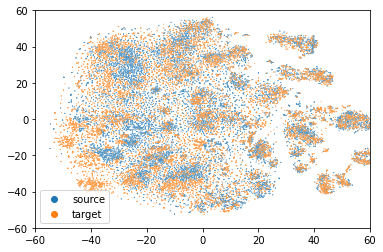

In [16]:
sns.scatterplot(x[:,0], x[:,1], s=[1]*x.shape[0], hue=['source']*xTrain.shape[0]+['target']*xTest.shape[0], marker='o')
plt.ylim(-60,60)
plt.xlim(-60,60)

plt.savefig('tsne_all_diff_language.png')

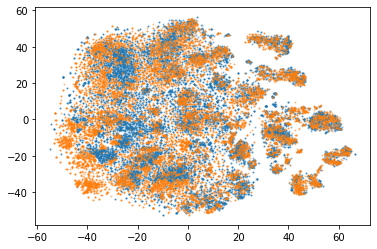

In [18]:
plt.scatter(xTrain[:,0], xTrain[:,1], s=1, alpha=0.4, marker='o')
plt.scatter(xTest[:,0], xTest[:,1], s=1, alpha=0.4, marker='o')